# HCA paper 

- Purpose: Reproduce Fig4(left), returns vs. episodes in Delayed Effect Environment
- Compare training curves for policy gradient (baseline), return HCA, and state HCA.  All employing 3-step bootstrapping, where aliased chain is size 4.  Expect policy gradient to fail, but HCA to figure this out.

Resulting plot reproduces qualitative behavior of return HCA vs. policy gradient, but not state HCA (which isn't learning => need to debug).

In [41]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import hca.tabular_actor_critic as tabular_actor_critic
from hca.tabular_vpg import vpg
from hca.envs.delayed_effect_env import DelayedEffectEnv

%matplotlib inline

In [42]:
vpg_config = dict(
    actor_critic=tabular_actor_critic.TabularVPGActorCritic,
    ac_kwargs={'pi_lr': 0.2, 'vf_lr': 0.2},
    algo='vpg',
)

In [43]:
returnHCA_config = dict(
    actor_critic=tabular_actor_critic.TabularReturnHCA,
    ac_kwargs={'pi_lr': 0.2, 'vf_lr': 0.2, 'h_lr': 0.2, 
               'return_bins': np.array([-1,0,1])},
    algo='returnHCA',
)

In [44]:
stateHCA_config = dict(
    actor_critic=tabular_actor_critic.TabularStateHCA,
    ac_kwargs={'pi_lr': 0.2, 'vf_lr': 0.2, 'h_lr': 0.2},
    algo='stateHCA',
)

In [45]:
config = dict(
    env_kwargs={'OHE_obs': False,
                'n': 4,
                'final_reward': 1.0,
                'sigma': 0.0},
    n_episodes=500,
    n_test_episodes=100,
    gamma=1.0,
    lam=1.0,
    bootstrap_n=3
)

In [46]:
num_runs = 100
algo_configs = [vpg_config, returnHCA_config, stateHCA_config]

In [ ]:
for algo_conf in algo_configs:
    algo_name = algo_conf.pop('algo')
    for i in range(num_runs):
        logger_out_dir = os.path.join('.', algo_name, f"{i:03}")
        logger_kwargs = {'exp_name': 'hca', 'output_dir': logger_out_dir}
    
        vpg(env_fn=DelayedEffectEnv, **config, **algo_conf,
            logger_kwargs=logger_kwargs)

# Read in results for the 100 independent runs per algo (over 500 episodes), calculate means and standard deviations, and plot against each other

In [48]:
import glob

vpg_logs = glob.glob('vpg/*/progress.txt')
returnHCA_logs = glob.glob('returnHCA/*/progress.txt')
stateHCA_logs = glob.glob('stateHCA/*/progress.txt')

In [50]:
def run_results(n_episodes, num_runs, log_names):
    assert len(log_names) == num_runs
    test_ep_ret = np.zeros((n_episodes, num_runs))
    ep_ret = np.zeros((n_episodes, num_runs))

    for idx, log in enumerate(log_names):
        df = pd.read_table(log)
        test_ep_ret[:,idx] = df.AverageTestEpRet.values
        ep_ret[:,idx] = df.EpRet.values
        
    return pd.DataFrame(test_ep_ret), pd.DataFrame(ep_ret)

In [51]:
n_episodes = config['n_episodes']

vpg_test_ep_ret, vpg_ep_ret = run_results(n_episodes, num_runs, vpg_logs)
returnHCA_test_ep_ret, returnHCA_ep_ret = run_results(n_episodes, num_runs, returnHCA_logs)
stateHCA_test_ep_ret, stateHCA_ep_ret = run_results(n_episodes, num_runs, stateHCA_logs)

In [64]:
returnHCA_mean_test_ep_ret.tail()

495    0.6568
496    0.6658
497    0.6454
498    0.6532
499    0.6450
dtype: float64

In [65]:
vpg_mean_test_ep_ret = vpg_test_ep_ret.mean(axis=1)
vpg_std_test_ep_ret = vpg_test_ep_ret.std(axis=1)
returnHCA_mean_test_ep_ret = returnHCA_test_ep_ret.mean(axis=1)
returnHCA_std_test_ep_ret = returnHCA_test_ep_ret.std(axis=1)
stateHCA_mean_test_ep_ret = stateHCA_test_ep_ret.mean(axis=1)
stateHCA_std_test_ep_ret = stateHCA_test_ep_ret.std(axis=1)

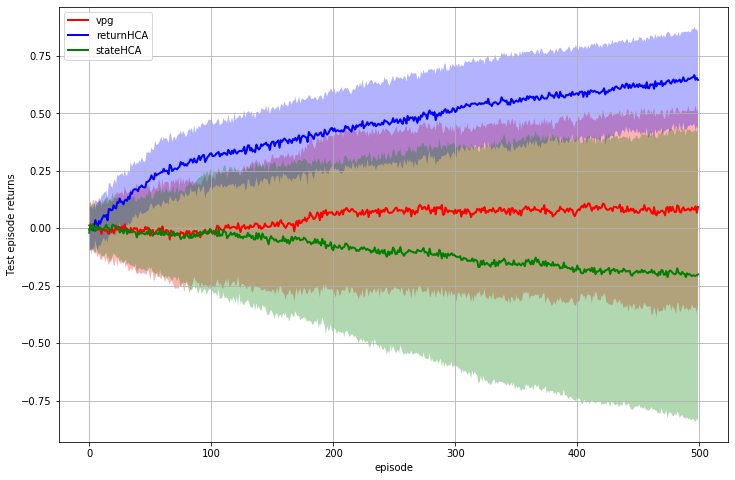

In [66]:
# plot test returns
plt.rcParams["figure.figsize"] = (12,8)
epochs = range(n_episodes)
alpha=0.3

fig, ax = plt.subplots(1)
ax.plot(epochs, vpg_mean_test_ep_ret, lw=2, label='vpg', color='red')
ax.plot(epochs, returnHCA_mean_test_ep_ret, lw=2, label='returnHCA', color='blue')
ax.plot(epochs, stateHCA_mean_test_ep_ret, lw=2, label='stateHCA', color='green')
ax.fill_between(epochs, 
                vpg_mean_test_ep_ret+vpg_std_test_ep_ret, 
                vpg_mean_test_ep_ret-vpg_std_test_ep_ret, 
                facecolor='red', alpha=alpha)
ax.fill_between(epochs, 
                returnHCA_mean_test_ep_ret+returnHCA_std_test_ep_ret, 
                returnHCA_mean_test_ep_ret-returnHCA_std_test_ep_ret, 
                facecolor='blue', alpha=alpha)
ax.fill_between(epochs, 
                stateHCA_mean_test_ep_ret+stateHCA_std_test_ep_ret, 
                stateHCA_mean_test_ep_ret-stateHCA_std_test_ep_ret, 
                facecolor='green', alpha=alpha)
ax.legend(loc='upper left')
ax.set_xlabel('episode')
ax.set_ylabel('Test episode returns')
ax.grid()

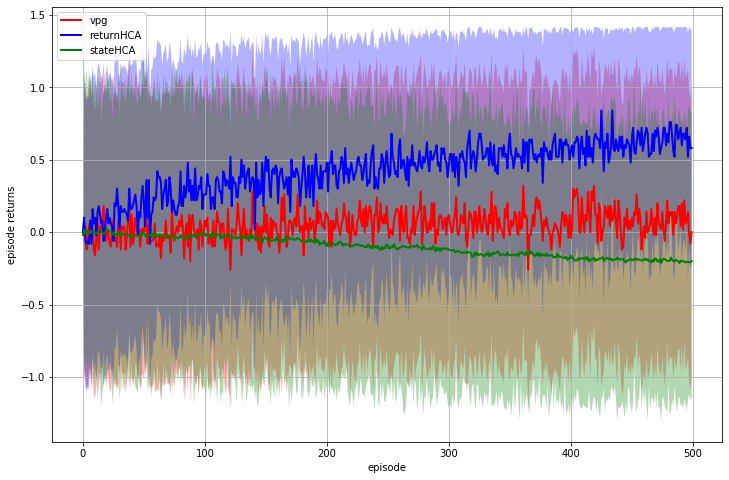

In [67]:
vpg_mean_ep_ret = vpg_ep_ret.mean(axis=1)
vpg_std_ep_ret = vpg_ep_ret.std(axis=1)
returnHCA_mean_ep_ret = returnHCA_ep_ret.mean(axis=1)
returnHCA_std_ep_ret = returnHCA_ep_ret.std(axis=1)
stateHCA_mean_ep_ret = stateHCA_ep_ret.mean(axis=1)
stateHCA_std_ep_ret = stateHCA_ep_ret.std(axis=1)

# plot test returns
plt.rcParams["figure.figsize"] = (12,8)
epochs = range(n_episodes)
alpha=0.3

fig, ax = plt.subplots(1)
ax.plot(epochs, vpg_mean_ep_ret, lw=2, label='vpg', color='red')
ax.plot(epochs, returnHCA_mean_ep_ret, lw=2, label='returnHCA', color='blue')
ax.plot(epochs, stateHCA_mean_test_ep_ret, lw=2, label='stateHCA', color='green')
ax.fill_between(epochs, 
                vpg_mean_ep_ret+vpg_std_ep_ret, 
                vpg_mean_ep_ret-vpg_std_ep_ret, 
                facecolor='red', alpha=alpha)
ax.fill_between(epochs, 
                returnHCA_mean_ep_ret+returnHCA_std_ep_ret, 
                returnHCA_mean_ep_ret-returnHCA_std_ep_ret, 
                facecolor='blue', alpha=alpha)
ax.fill_between(epochs, 
                stateHCA_mean_ep_ret+stateHCA_std_ep_ret, 
                stateHCA_mean_ep_ret-stateHCA_std_ep_ret, 
                facecolor='green', alpha=alpha)
ax.legend(loc='upper left')
ax.set_xlabel('episode')
ax.set_ylabel('episode returns')
ax.grid()